In [8]:
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

# load the dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

# Define the full Pipeline as a function
def PipelineCluster(n_components=2, n_clusters=3):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components, random_state=0)),
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=0))
    ])

# Fit pipeline and predict clusters
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(df)
df["Cluster"] = pipeline_cluster.named_steps["kmeans"].labels_

df[["Cluster"]].value_counts()

Cluster
0          358
2          120
1           91
Name: count, dtype: int64

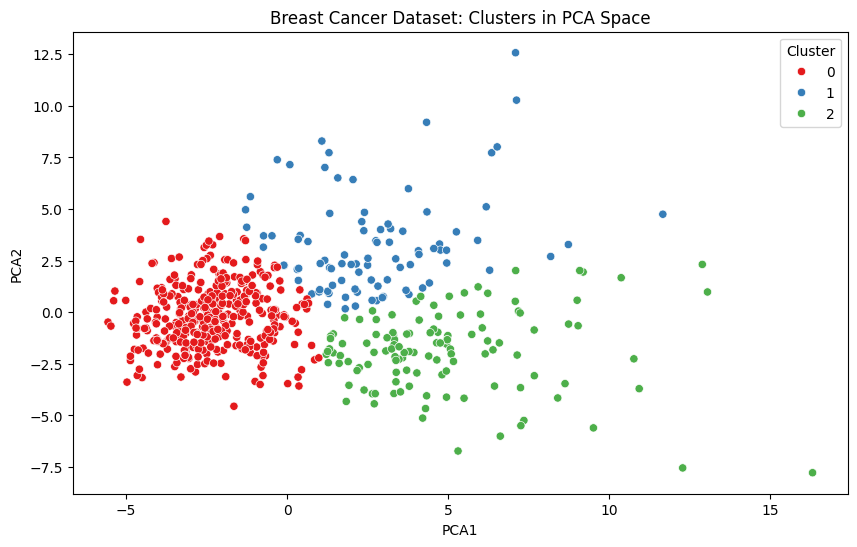

In [9]:
pca_vis = PCA(n_components=2)
df_vis_scaled = StandardScaler().fit_transform(
    SimpleImputer(strategy='median').fit_transform(df.drop("Cluster", axis=1)))
df_pca_2d = pca_vis.fit_transform(df_vis_scaled)

import seaborn as sns
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(df_pca_2d, columns=["PCA1", "PCA2"])
df_plot["Cluster"] = df["Cluster"]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x="PCA1", y="PCA2", hue="Cluster", palette="Set1")
plt.title("Breast Cancer Dataset: Clusters in PCA Space")
plt.show()



In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df.drop("Cluster", axis=1)
y = df["Cluster"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("selector", SelectFromModel(GradientBoostingClassifier(random_state=0))),
    ("classifier", GradientBoostingClassifier(random_state=0))
])

clf_pipeline.fit(X_train, y_train)
print(classification_report(y_test, clf_pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       0.90      0.76      0.83        25
           2       0.85      0.92      0.88        25

    accuracy                           0.92       114
   macro avg       0.90      0.89      0.89       114
weighted avg       0.92      0.92      0.92       114



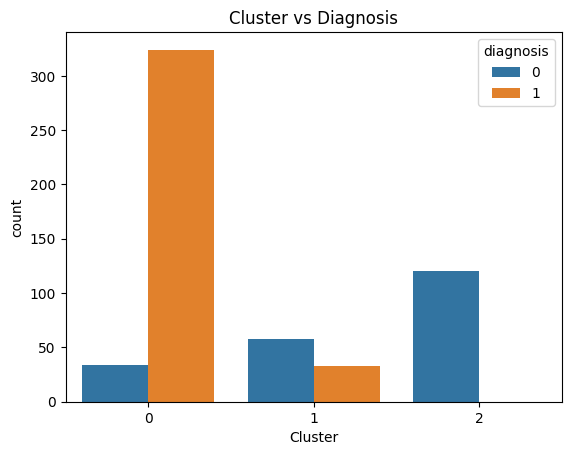

In [11]:
df["diagnosis"] = data.target # 0=malignant, 1=benign
sns.countplot(data=df, x="Cluster", hue="diagnosis")
plt.title("Cluster vs Diagnosis")
plt.show()


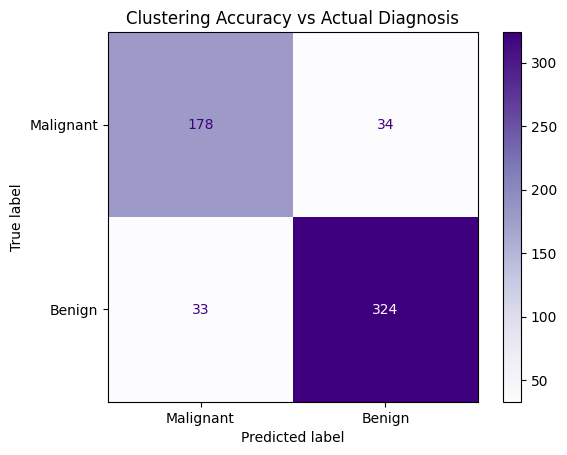

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       212
           1       0.91      0.91      0.91       357

    accuracy                           0.88       569
   macro avg       0.87      0.87      0.87       569
weighted avg       0.88      0.88      0.88       569



In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

df["Diagnosis"] = data.target # 0=malignant. and 1=benign

# Map each cluster to teh most common actual diagnosis in that cluster
cluster_diagnosis_map = pd.crosstab(df["Cluster"], df["Diagnosis"])
cluster_to_diagnosis = {
    cluster_label: cluster_diagnosis_map.loc[cluster_label].idxmax()
    for cluster_label in cluster_diagnosis_map.index
}

# Map predict clusters to diagnosis
df["PredictedDiagnosis"] = df["Cluster"].map(cluster_to_diagnosis)

# Evaluate using a confusion matrix and classification report
cm = confusion_matrix(df["Diagnosis"], df["PredictedDiagnosis"])
report = classification_report(df["Diagnosis"], df["PredictedDiagnosis"])

# Show the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Malignant", "Benign"])
disp.plot(cmap="Purples", values_format='d')
plt.title("Clustering Accuracy vs Actual Diagnosis")
plt.show()

# print the classification report
print(report)
